# Análisis Detallado de los Datos de Yelp

Con el objetivo de brindar a nuestro cliente una visión más completa del mercado de restaurantes latinos en Estados Unidos, y asimismo, nuestro cliente  nuestro cliente pueda tomar decisiones más informadas, llevaremos a cabo un análisis exhaustivo del conjunto de datos de Yelp.

### Importamos las librerías 

In [136]:
import pandas as pd
import numpy as np
import json # Para trabajar con JSON
from pandas import json_normalize
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.corpus import stopwords
#from sklearn.preprocessing import StandardScaler, OneHotEncoder

#Descargar los stopwords en español e inglés
nltk.download('stopwords')
stop_words = set(stopwords.words('english') + stopwords.words('spanish'))

# Configurar estilo de visualización
sns.set(style="whitegrid", palette="muted")
#plt.rcParams["figure.figsize"] = (12, 6)

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to C:\Users\JS
[nltk_data]     Digital\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Carga de Archivo business

In [137]:
data_business = pd.read_pickle('D:/2024/HenryData/PF/Datos_Crudos/yelp/business.pkl')

In [138]:
data_business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
# Recorte del las columnas duplicadas
df_business = data_business.iloc[:, :14]

In [140]:
df_business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."


In [141]:
df_business.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   business_id   150346 non-null  object
 1   name          150346 non-null  object
 2   address       150346 non-null  object
 3   city          150346 non-null  object
 4   state         150343 non-null  object
 5   postal_code   150346 non-null  object
 6   latitude      150346 non-null  object
 7   longitude     150346 non-null  object
 8   stars         150346 non-null  object
 9   review_count  150346 non-null  object
 10  is_open       150346 non-null  object
 11  attributes    136602 non-null  object
 12  categories    150243 non-null  object
 13  hours         127123 non-null  object
dtypes: object(14)
memory usage: 17.2+ MB


In [142]:
df_business.columns.tolist()

['business_id',
 'name',
 'address',
 'city',
 'state',
 'postal_code',
 'latitude',
 'longitude',
 'stars',
 'review_count',
 'is_open',
 'attributes',
 'categories',
 'hours']

De acuerdo con la información que contiene el dataset business, se observa que se tiene 14 columnas, las cuales se describe y detalla a continuación:

1. business_id: Identificador único de cada negocio. Es de tipo objecto y no tiene valores nulos. Ejemplo: 'Pns2l4eNsfO8kk83dixA6A'.

2. name: Nombre del negocio. Es de tipo objecto y no tiene valores nulos. Ejemplo: 'Abby Rappoport, LAC, CMQ'.

3. address: Dirección física del negocio. Es de tipo objecto y no tiene valores nulos. Ejemplo: '1616 Chapala St, Ste 2'.

4. city: Ciudad donde se encuentra el negocio. Es de tipo objecto y no tiene valores nulos. Ejemplo: 'Santa Barbara'.

5. state: Estado donde se encuentra el negocio. Es de tipo objecto y contiene 3 valores nulos. Ejemplo: 'CA'.

6. postal_code: Código postal asociado a la dirección del negocio. Es de tipo objecto y no tiene valores nulos. Ejemplo: '93101'.

7. latitude: Coordenada de latitud de la ubicación del negocio. Es de tipo objecto, pero debería convertirse en un float para facilitar el análisis geoespaciales. Ejemplo: '34.426679'.

8. longitude: Coordenada de longitud de la ubicación del negocio. Es de tipo objecto, pero debería convertirse en un float. Ejemplo: '-119.711197'.

9. stars: Calificación promedio del negocio en estrellas (en una escala de 1 a 5). Es de tipo objecto, pero debería convertirse en un float. Ejemplo: '5.0'.

10. review_count: Número de reseñas que ha recibido el negocio. Es de tipo objecto, pero debería convertirse en un int. Ejemplo: '7'.

11. is_open: Indicador de si el negocio está abierto (1) o cerrado (0). Es de tipo objecto, pero debería convertirse en int. Ejemplo: '0'.

12. attributes: Información adicional sobre el negocio, almacenada en formato JSON o similar. Contiene valores nulos y es de tipo objecto. Requiere procesamiento para desandar los datos. Ejemplo: {'ByAppointmentOnly': 'True'}.

13. categories: Categorías asociadas al negocio, almacenadas como una lista de valores separados por comas. Contiene 103 valores nulos y es de tipo objecto. Ejemplo: 'Doctors, Traditional Chinese Medicine, Naturopathy'.

14. hours: Horarios de operación del negocio, almacenados en formato JSON o similar. Contiene valores nulos y es de tipo objecto. Requiere procesamiento para desandar los datos. Ejemplo: {'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0'}.

### Análisis General: 
Con el objetivo de: Identificar las categorías más populares permite focalizar análisis en sectores clave.

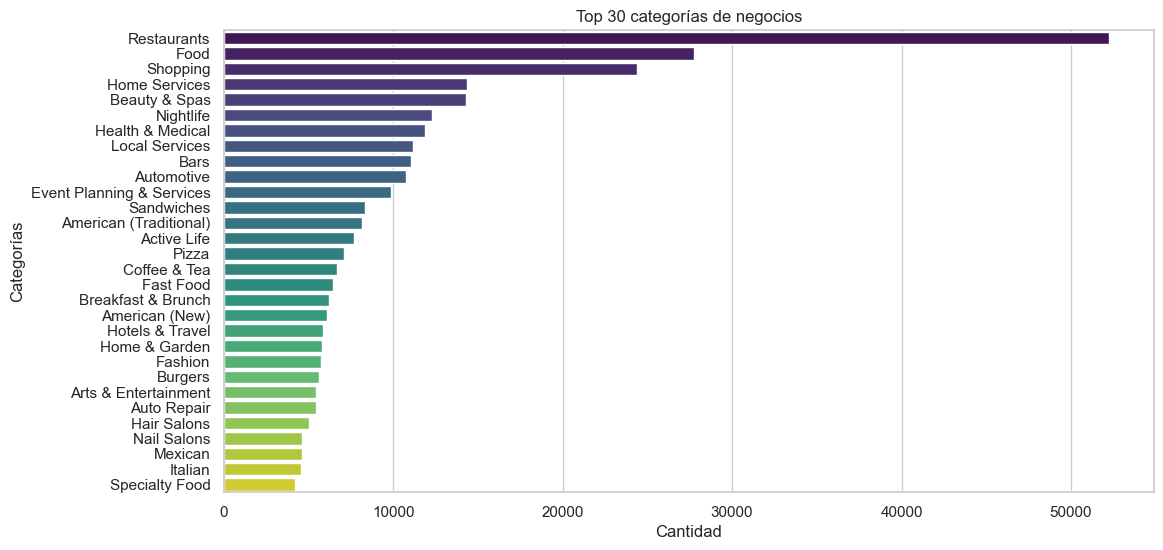

In [143]:
# Contar las categorías más comunes
df_business["categories"] = df_business["categories"].fillna("").apply(lambda x: x.split(", "))
categories = df_business["categories"].explode().value_counts().head(30)

# Visualizar las categorías más comunes
plt.figure(figsize=(12, 6))
sns.barplot(x=categories.values, y=categories.index, palette="viridis")
plt.title("Top 30 categorías de negocios")
plt.xlabel("Cantidad")
plt.ylabel("Categorías")
plt.show()

**Conclusión:**

La categoría que predomina en el df_business, es la relacionada a alimentación, restaurantes y comida, ocupando los dos primeros lugares; también se observan otras categorías relacionadas al sector alimentación como son los sándwiches, pizza, comida rápida, etc. En ese sentido nuestro análisis está centrado en el  sector alimentación, enfocándonos principalmente en la categoría Restaurantes.


### Filtramos el dataframe business enfocando nuestro análisis al sector alimentación

In [144]:
# Realizamos un copy del Dataframe original
df_business1 = data_business.iloc[:, :14].copy()

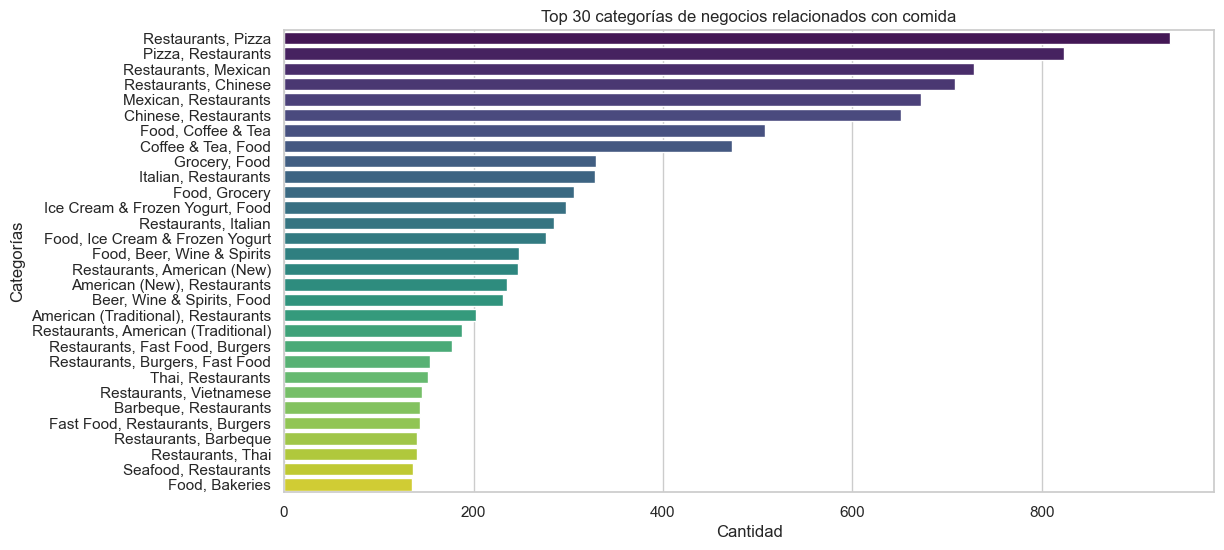

In [145]:
# Opción 1: Rellenar los valores nulos con una cadena vacía antes de aplicar la función
df_business1['categories'] = df_business1['categories'].fillna("")

# Opción 2: Filtrar los valores no nulos antes de aplicar la función (recomendado)
df_business_filtered = df_business1.dropna(subset=['categories'])  # Elimina filas con categorías nulas

# Crear la columna booleana para comida (utilizando el DataFrame filtrado)
df_business_filtered['is_food_related'] = df_business_filtered['categories'].apply(lambda x: any(word in x for word in ['Restaurants', 'Food', 'Pizza', 'Burgers', 'Sandwiches', 'Mexican', 'Italian', 'Chinese', 'Japanese', 'Thai', 'Indian', 'Coffee', 'Tea']))

# Filtrar los negocios relacionados con comida
df_food = df_business_filtered[df_business_filtered['is_food_related']]

# Contar las categorías más comunes de comida
categories_food = df_food["categories"].explode().value_counts().head(30)

# Visualizar las categorías más comunes de comida
plt.figure(figsize=(12, 6))
sns.barplot(x=categories_food.values, y=categories_food.index, palette="viridis")
plt.title("Top 30 categorías de negocios relacionados con comida")
plt.xlabel("Cantidad")
plt.ylabel("Categorías")
plt.show()

**Conclusión:**

- El gráfico muestra que Restaurants Pizza o Pizza, Restaurants predomina como una de las principales categorías; seguido de Restaurants, mexicana y muchas otras combinaciones más como italiana, asiática, etc. Esto refleja la multiculturalidad de la población estadounidense y su gusto por diferentes sabores.
- Además la creciente demanda por comida latina, hace que nuestro análisis se enfoque en restaurantes que brindan alimentos de origen latino, para ello se segmentará aún más el dataset. 


### Análisis de restaurantes latinos

Construimos un diccionario con las palabras claves asociadas a los restaurantes de tipo latino

In [146]:
# Diccionario de palabras clave asociadas a cada tipo de restaurante latino
categoria_restaurante = {
    'restaurante argentino': ['argentine', 'argentinian', 'argentinian restaurant'],
    'restaurante mexicano': ['mexican', 'mexican restaurant', 'burrito', 'taco', 'pozole', 'Oaxacan'],
    'restaurante colombiano': ['colombian', 'colombian restaurant'],
    'restaurante peruano': ['peruvian', 'peruvian restaurant'],
    'restaurante brasileño': ['brazilian', 'brazilian restaurant'],
    'restaurante cubano': ['cuban', 'cuban restaurant'],
    'restaurante venezolano': ['venezuelan', 'venezuelan restaurant'],
    'restaurante chileno': ['chilean', 'chilean restaurant'],
    'restaurante ecuatoriano': ['ecuadorian', 'ecuadorian restaurant'],
    'restaurante dominicano': ['dominican', 'dominican restaurant'],
    'restaurante centroamericano': ['honduran', 'guatemalan', 'nicaraguan', 'panamanian', 'salvadoran', 'costarican', 'costa rican restaurant', 'honduran restaurant'],
    'restaurante caribeño': ['caribbean', 'caribbean restaurant'],
    'restaurante latinoamericano': ['latin american food', 'latin american', 'south american', 'latin', 'hispanic', 'south american restaurant'],
    'restaurante boliviano': ['bolivian', 'bolivian restaurant'],
    'restaurante paraguayo': ['paraguayan', 'paraguayan restaurant'],
    'restaurante uruguayo': ['uruguayan', 'uruguayan restaurant'],
    'restaurante puertorriqueño': ['puerto rican', 'puerto rican restaurant']
}

# Función para categorizar los restaurantes
def categorizar_restaurante(categoria):
    if isinstance(categoria, str):  # Verificar que la categoría es una cadena
        for categoria_nombre, keywords in categoria_restaurante.items():
            if any(keyword.lower() in categoria.lower() for keyword in keywords):
                return categoria_nombre
    return 'otros'  # Si no coincide con ninguna categoría o no es cadena, clasificar como 'otros'

In [147]:
# Aplicar la función a la columna 'categories' para crear una nueva columna 'restaurante_categoria'
df_food['restaurante_categoria'] = df_food['categories'].apply(categorizar_restaurante)

In [148]:
# Verificar las primeras filas con la nueva columna
df_food.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,is_food_related,restaurante_categoria
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None,True,otros
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",True,otros


In [149]:
# Análisis detallado del DataFrame
# 1. Contar el número de restaurantes por categoría
conteo_categorias = df_food['restaurante_categoria'].value_counts()
print("\nConteo por categoría:")
print(conteo_categorias)


Conteo por categoría:
restaurante_categoria
otros                          59474
restaurante mexicano            4611
restaurante caribeño             471
restaurante cubano               256
restaurante latinoamericano      204
restaurante brasileño             84
restaurante peruano               69
restaurante colombiano            59
restaurante venezolano            39
restaurante centroamericano       38
restaurante argentino             34
restaurante dominicano            28
Name: count, dtype: int64


In [150]:
# 2. Filtrar solo los restaurantes latinos para análisis adicional
restaurantes_latinos = df_food[df_food['restaurante_categoria'] != 'otros']

In [151]:
restaurantes_latinos.shape

(5893, 16)

In [152]:
restaurantes_latinos.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,is_food_related,restaurante_categoria
104,Dy91wdWkwtI_qgjAIZ0Niw,Taqueria Los Primos,3322 Old Capitol Trl,Wilmington,IN,19808,39.732089,-75.625673,4.0,23,1,"{'BusinessAcceptsCreditCards': 'True', 'HasTV'...","Mexican, Restaurants",None,True,restaurante mexicano
153,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,10160 Ulmerton Rd,Largo,IN,33771,27.894167,-82.779866,3.0,19,1,"{'RestaurantsPriceRange2': '1', 'Caters': 'Tru...","Mexican, Fast Food, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '10:45-22:0',...",True,restaurante mexicano


In [153]:
restaurantes_latinos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5893 entries, 104 to 150336
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   business_id            5893 non-null   object
 1   name                   5893 non-null   object
 2   address                5893 non-null   object
 3   city                   5893 non-null   object
 4   state                  5893 non-null   object
 5   postal_code            5893 non-null   object
 6   latitude               5893 non-null   object
 7   longitude              5893 non-null   object
 8   stars                  5893 non-null   object
 9   review_count           5893 non-null   object
 10  is_open                5893 non-null   object
 11  attributes             5798 non-null   object
 12  categories             5893 non-null   object
 13  hours                  5068 non-null   object
 14  is_food_related        5893 non-null   bool  
 15  restaurante_categoria 

In [154]:
# Verificar valores nulos
nulos_df = restaurantes_latinos.isnull().sum()
print("Valores faltantes por columna:")
print(nulos_df[nulos_df > 0])

Valores faltantes por columna:
attributes     95
hours         825
dtype: int64


Imputamos los valores nulos

In [155]:
restaurantes_latinos['attributes'] = restaurantes_latinos['attributes'].fillna('Desconocido')
restaurantes_latinos['hours'] = restaurantes_latinos['hours'].fillna('No Data')

Las columnas: latitude, longitude, stars, y review_count actualmente son de tipo object, se convertirán en numéricos

In [156]:
restaurantes_latinos['latitude'] = pd.to_numeric(restaurantes_latinos['latitude'], errors='coerce')
restaurantes_latinos['longitude'] = pd.to_numeric(restaurantes_latinos['longitude'], errors='coerce')
restaurantes_latinos['stars'] = pd.to_numeric(restaurantes_latinos['stars'], errors='coerce')
restaurantes_latinos['review_count'] = pd.to_numeric(restaurantes_latinos['review_count'], errors='coerce')

Duplicados, si hay se elimina

In [157]:
restaurantes_latinos = restaurantes_latinos.drop_duplicates(subset='business_id')

In [158]:
restaurantes_latinos.shape

(5893, 16)

Análisis de la distribución de restaurantes latinos por categorías

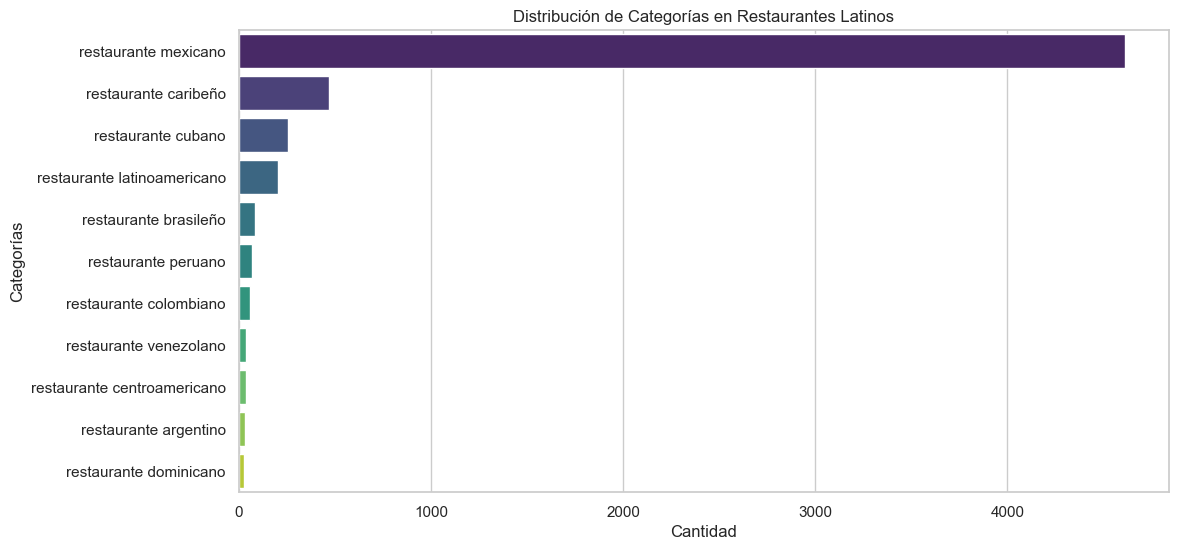

In [159]:
# Limpiar la columna 'restaurante_categoria' para eliminar corchetes
restaurantes_latinos["restaurante_categoria"] = restaurantes_latinos["restaurante_categoria"].str.strip("[]").str.split(", ")

# Contar la frecuencia de cada categoría
categorias = restaurantes_latinos["restaurante_categoria"].explode().value_counts()

# Visualizar las categorías más comunes de comida
plt.figure(figsize=(12, 6))
sns.barplot(x=categorias.values, y=categorias.index, palette="viridis")
plt.title("Distribución de Categorías en Restaurantes Latinos")
plt.xlabel("Cantidad")
plt.ylabel("Categorías")
plt.show()

Interpretación:
- La barra correspondiente a "restaurante mexicano" es significativamente más larga que las demás, lo que indica que la cocina mexicana es la más popular entre los consumidores estadounidenses.
- El gráfico también muestra una presencia considerable de otras cocinas latinoamericanas como la caribeña, cubana, brasileña y peruana. Esto sugiere que existe un creciente interés por explorar la diversidad culinaria de la región latinoamericana.
- Las cocinas colombiana, venezolana, centroamericana, argentina y dominicana, aunque presentes, tienen una representación menor en comparación con las más populares. 

*En conclusión*, el gráfico nos ofrece una visión general de la diversidad de la gastronomía latina en Estados Unidos y la predominancia de la cocina mexicana. Sin embargo, la creciente popularidad de las cocinas latinoamericanas sugiere que esta tendencia continuará en los próximos años, ofreciendo nuevas oportunidades para los emprendedores del sector gastronómico.

In [160]:
restaurantes_latinos.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,is_food_related,restaurante_categoria
104,Dy91wdWkwtI_qgjAIZ0Niw,Taqueria Los Primos,3322 Old Capitol Trl,Wilmington,IN,19808,39.732089,-75.625673,4.0,23,1,"{'BusinessAcceptsCreditCards': 'True', 'HasTV'...","Mexican, Restaurants",No Data,True,[restaurante mexicano]
153,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,10160 Ulmerton Rd,Largo,IN,33771,27.894167,-82.779866,3.0,19,1,"{'RestaurantsPriceRange2': '1', 'Caters': 'Tru...","Mexican, Fast Food, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '10:45-22:0',...",True,[restaurante mexicano]


Se ha Observado que las columnas: 'city' y 'state' no se corresponden por lo que se crea un función que asigne en una nueva columna el 'name_state' al cual, se asignará el estado por sus coordenadas de latitude y logitude.

Para crear esta nueva columna 'name_state', se utilizará un  archivo shapefile 'cb_2018_us_state_5m.shp', que contiene información sobre los estados de EE. UU., incluyendo sus códigos, nombres, áreas y límites geográficos.

In [161]:
#Importamos las librerias a utilizar
import geopandas as gpd
from shapely.geometry import Point

In [162]:
# Cargar shapefile con los límites de los estados
shapefile_path = "D:/2024/HenryData/PF/Otros/detalle_geoespacial/cb_2018_us_state_5m.shp"  # Reemplaza con la ruta a tu archivo shapefile
states = gpd.read_file(shapefile_path)

In [163]:
print(states.head(2))
print(states.columns)

  STATEFP   STATENS     AFFGEOID GEOID STUSPS        NAME LSAD         ALAND  \
0      31  01779792  0400000US31    31     NE    Nebraska   00  198956658395   
1      53  01779804  0400000US53    53     WA  Washington   00  172112588220   

        AWATER                                           geometry  
0   1371829134  POLYGON ((-104.05351 41.15726, -104.05267 41.2...  
1  12559278850  MULTIPOLYGON (((-122.32834 48.02134, -122.3217...  
Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


Este archivo 'cb_2018_us_state_5m.shp', contiene la siguiente información según sus columnas:

1. STATEFP: Código del estado (2 dígitos).

2. STATENS: Número de entidad del estado.

3. AFFGEOID: Identificador único del estado asignado por la Oficina del Censo de EE. UU.

4. GEOID: Identificador geográfico del estado.

5. STUSPS: Abreviatura del estado (código postal de 2 letras).

6. NAME: Nombre completo del estado.

7. LSAD: Clase de subdivisión de área de tierra (generalmente 00 para estados).

8. ALAND: Área de tierra del estado en metros cuadrados.

9. AWATER: Área de agua del estado en metros cuadrados.

10. geometry: Geometría del estado, representada como un polígono o multipolígono (coordenadas de los límites del estado).

In [164]:
# Simplificar geometrías (opcional, para mejorar el rendimiento si el archivo es muy pesado)
states['geometry'] = states['geometry'].simplify(0.01)

# Crear un índice espacial para mejorar la velocidad
states_sindex = states.sindex

In [165]:
# Función para asignar estado
def assign_state(lat, lon):
    # Crear un punto con las coordenadas dadas
    point = Point(lon, lat)
    # Encontrar posibles intersecciones con el índice espacial
    possible_matches_index = list(states_sindex.intersection(point.bounds))
    possible_matches = states.iloc[possible_matches_index]
    for _, state in possible_matches.iterrows():
        if state['geometry'].contains(point):
            return state['NAME']  # Usar la columna 'NAME' para el nombre del estado
    return 'Estado no encontrado'

In [166]:
# Aplicar la función para crear la columna 'state_name'
restaurantes_latinos['state_name'] = restaurantes_latinos.apply(
    lambda row: assign_state(row['latitude'], row['longitude']), axis=1
)

In [167]:
# Ver los resultados
restaurantes_latinos.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,is_food_related,restaurante_categoria,state_name
104,Dy91wdWkwtI_qgjAIZ0Niw,Taqueria Los Primos,3322 Old Capitol Trl,Wilmington,IN,19808,39.732089,-75.625673,4.0,23,1,"{'BusinessAcceptsCreditCards': 'True', 'HasTV'...","Mexican, Restaurants",No Data,True,[restaurante mexicano],Delaware
153,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,10160 Ulmerton Rd,Largo,IN,33771,27.894167,-82.779866,3.0,19,1,"{'RestaurantsPriceRange2': '1', 'Caters': 'Tru...","Mexican, Fast Food, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '10:45-22:0',...",True,[restaurante mexicano],Florida


In [168]:
restaurantes_latinos.shape

(5893, 17)

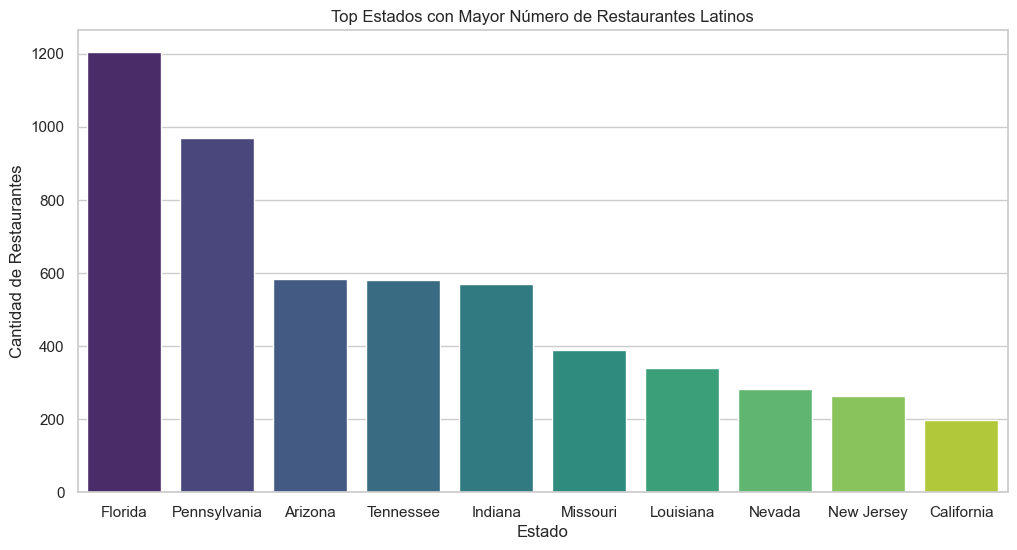

In [169]:
# Contar restaurantes por estado
restaurantes_por_estado = restaurantes_latinos['state_name'].value_counts().reset_index()
restaurantes_por_estado.columns = ['state_name', 'count']

# Visualizar
plt.figure(figsize=(12, 6))
sns.barplot(data=restaurantes_por_estado.head(10), x='state_name', y='count', palette='viridis')
plt.title("Top Estados con Mayor Número de Restaurantes Latinos")
plt.xlabel("Estado")
plt.ylabel("Cantidad de Restaurantes")
plt.show()

Interpretación:
- Florida encabeza la lista con una cantidad significativamente mayor de restaurantes latinos en comparación con los otros estados. Esto sugiere que la cultura y la gastronomía latina tienen una fuerte presencia en este estado, posiblemente debido a una gran población latina o a una alta demanda de comida latina por parte de los residentes.
- Pennsylvania y Arizona ocupan el segundo y tercer lugar respectivamente, indicando también una importante presencia de restaurantes latinos en estos estados.

Análisis Descriptivo de las columnas numéricas

In [170]:
print(restaurantes_latinos[['stars', 'review_count']].describe())

             stars  review_count
count  5893.000000    5893.00000
mean      3.605719      89.53606
std       0.841841     171.07196
min       1.000000       5.00000
25%       3.000000      14.00000
50%       3.500000      36.00000
75%       4.000000      92.00000
max       5.000000    3834.00000


Distribución de la variable is_open:

In [171]:
restaurantes_latinos['is_open'].value_counts()

is_open
1    4142
0    1751
Name: count, dtype: int64

Ciudades y estados más frecuentes

In [172]:
print('Ciudades más Frecuentes')
print(restaurantes_latinos['city'].value_counts().head(10))
print('Estados más frecuentes')
print(restaurantes_latinos['state_name'].value_counts().head(10))

Ciudades más Frecuentes
city
Tucson           544
Tampa            520
Philadelphia     491
Indianapolis     433
Nashville        331
Reno             201
New Orleans      192
Saint Louis      157
Santa Barbara    135
Boise            114
Name: count, dtype: int64
Estados más frecuentes
state_name
Florida         1204
Pennsylvania     968
Arizona          583
Tennessee        582
Indiana          569
Missouri         389
Louisiana        341
Nevada           283
New Jersey       263
California       199
Name: count, dtype: int64


Distribución de categorías: Observamos que la categoría Mexicana es la más polular

In [173]:
from collections import Counter
categorias = restaurantes_latinos['categories'].str.split(', ').explode()
print(Counter(categorias).most_common(10))

[('Restaurants', 5878), ('Mexican', 4600), ('Food', 1276), ('Tacos', 1020), ('Fast Food', 902), ('Latin American', 810), ('Nightlife', 788), ('Breakfast & Brunch', 787), ('Bars', 769), ('Tex-Mex', 769)]


Relación entre calificación y cantidad de reseñas

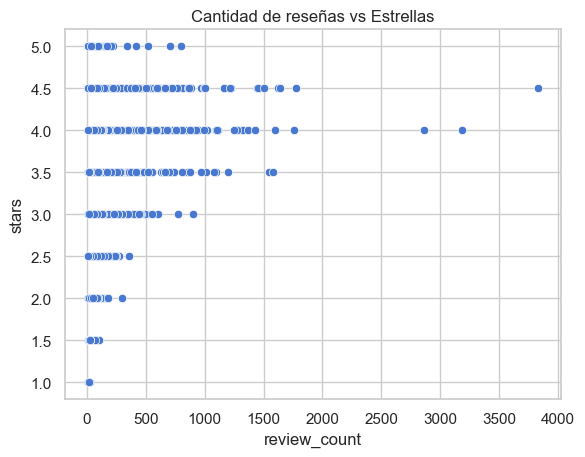

In [174]:
sns.scatterplot(data=restaurantes_latinos, x='review_count', y='stars')
plt.title('Cantidad de reseñas vs Estrellas')
plt.show()

Interpretación:
- Se observa una clara tendencia: los restaurantes con un mayor número de reseñas tienden a tener calificaciones más altas. Esto sugiere que los clientes están más dispuestos a dejar reseñas cuando han tenido una experiencia positiva, lo que a su vez puede atraer a más clientes y generar un ciclo de retroalimentación positiva.
- Para cada valor de estrellas, existe un rango bastante amplio en el número de reseñas. Esto indica que la popularidad de un restaurante (medida por el número de reseñas) no está directamente relacionada con su calificación. Es decir, podemos encontrar restaurantes muy populares con calificaciones altas y bajas, así como restaurantes menos populares con calificaciones altas y bajas.
- No se observa una relación lineal perfecta entre el número de reseñas y la calificación. 

Restaurantes abiertos vs cerrados (is_open) y calificación:

Text(0.5, 1.0, 'Comparación de calificaciones entre abiertos y cerrados')

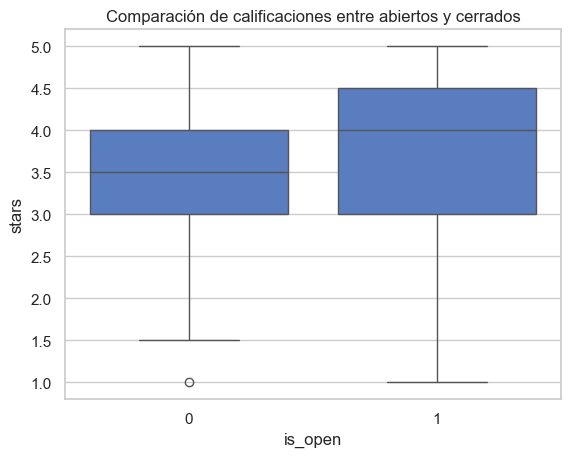

In [175]:
sns.boxplot(data=restaurantes_latinos, x='is_open', y='stars')
plt.title('Comparación de calificaciones entre abiertos y cerrados')

Interpretación:
- Las calificaciones para los restaurantes abiertos como cerrados presentan una distribución similar en sus calificaciones, La mediana (la línea central de cada caja) se encuentra alrededor de 3.5 y 4 estrellas para ambos grupos, respectivamente. Esto indica que, en general, tanto los restaurantes abiertos como los cerrados obtuvieron calificaciones promedio similares.

*En conclusión*, podemos decir, que la similitud en las calificaciones promedio sugiere que la calificación por sí sola no es un factor determinante para que un restaurante latino cierre.

Distribución geográfica de los restaurantes:

In [176]:
import os
import plotly.express as px

In [177]:
# Obtener el token de la variable de entorno
mapbox_token = os.environ.get('MAPBOX_ACCESS_TOKEN')

# Configurar el token en Plotly
px.set_mapbox_access_token(mapbox_token)

In [178]:
# Asegúrate de que las columnas 'latitude' y 'longitude' son numéricas
restaurantes_latinos['latitude'] = pd.to_numeric(restaurantes_latinos['latitude'], errors='coerce')
restaurantes_latinos['longitude'] = pd.to_numeric(restaurantes_latinos['longitude'], errors='coerce')

# Crear el mapa con markers
fig = px.scatter_mapbox(restaurantes_latinos,
                        lat="latitude",
                        lon="longitude",
                        hover_name="name",
                        hover_data=["city", 'state_name', "stars"],
                        zoom=5,
                        title="Restaurantes Latinos en EE.UU.")

# Configuración del estilo del mapa
fig.update_layout(mapbox_style="open-street-map")
fig.show()

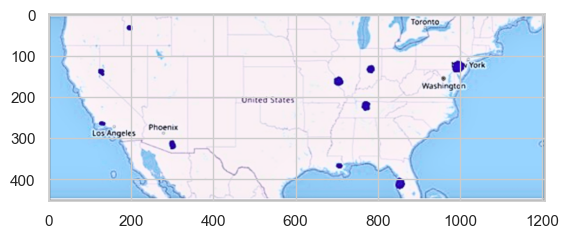

In [179]:
import matplotlib.image as mpimg
# Cargar la imagen
img = mpimg.imread('../Img/mapa1.png')
# Cargar la imagen
img1 = mpimg.imread('../Img/mapa2.png')

# Mostrar la imagen
plt.imshow(img)
plt.show()

Del análisis geográfico se ha obtenido el gráfico 'mapa1' donde se observa que:
- La mayoría de los restaurantes latinos se encuentran concentrados en las costas Este y Oeste de los Estados Unidos. Ciudades como Los Ángeles, Nueva York, Washington D.C. y Miami albergan un número considerable de estos establecimientos.
- Las ciudades marcadas en el mapa suelen tener una población latina significativa. Estas comunidades han establecido barrios y vecindarios donde la cultura y la gastronomía latina son prominentes, lo que a su vez atrae a una mayor cantidad de restaurantes.
- Los restaurantes latinos tienden a concentrarse en áreas urbanas, donde hay una mayor densidad de población y una mayor demanda de diversidad culinaria.

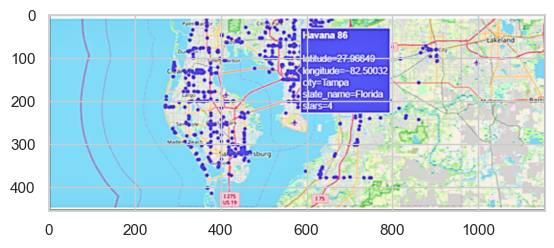

In [180]:
plt.imshow(img1)
plt.show()

Del análisis geogáfico se ha obtenido el gráfico 'mapa2'. El mapa muestra una concentración significativa de restaurantes latinos en ciertas áreas de los Estados Unidos, particularmente del Estado de Florida. Los puntos azules representan la ubicación de cada restaurante, además presenta un ejemplo del Restaurant latino 'Havana 86 donde se muestra información adicional como el nombre del restaurante, sus coordenadas geográficas (latitud y longitud), la ciudad y estado donde se encuentra, y la calificación (estrellas).

Análisis de la  columna attributes 

In [181]:
# Asegurarse de que la columna 'attributes' no tenga valores nulos
df = restaurantes_latinos.copy()  # Crear una copia de seguridad
df['attributes'] = df['attributes'].fillna('{}')  # Reemplazar NaN con diccionario vacío

# Verificar la transformación
print(df['attributes'].head(10))

104    {'BusinessAcceptsCreditCards': 'True', 'HasTV'...
153    {'RestaurantsPriceRange2': '1', 'Caters': 'Tru...
159    {'GoodForDancing': 'True', 'Smoking': 'u'no'',...
274    {'Caters': 'False', 'Alcohol': 'u'none'', 'Res...
278    {'GoodForKids': 'True', 'OutdoorSeating': 'Tru...
290    {'GoodForKids': 'True', 'RestaurantsReservatio...
291    {'BusinessAcceptsCreditCards': 'True', 'Alcoho...
345    {'RestaurantsGoodForGroups': 'True', 'Restaura...
348    {'RestaurantsPriceRange2': '2', 'RestaurantsGo...
351    {'BusinessAcceptsCreditCards': 'True', 'Restau...
Name: attributes, dtype: object


In [182]:
from pandas import json_normalize

# Expandir la columna 'attributes'
attributes_df = json_normalize(df['attributes'])

# Unir las nuevas columnas de atributos al DataFrame original
df_expanded = pd.concat([df.drop(columns='attributes'), attributes_df], axis=1)

Para unir todas las columnas que se expandieron a partir de la columnas 'attributes', creamos un nuev DataFrame 'df_expanded'

In [183]:
# Verificar el DataFrame resultante
df_expanded.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours,is_food_related,restaurante_categoria,state_name,BusinessAcceptsCreditCards,HasTV,OutdoorSeating,RestaurantsReservations,GoodForKids,RestaurantsPriceRange2,RestaurantsTakeOut,Caters,WiFi,RestaurantsAttire,NoiseLevel,BusinessParking,BikeParking,Alcohol,RestaurantsGoodForGroups,GoodForMeal,RestaurantsDelivery,Ambience,DriveThru,RestaurantsTableService,GoodForDancing,Smoking,CoatCheck,DogsAllowed,BestNights,Music,HappyHour,ByAppointmentOnly,BYOB,Corkage,BusinessAcceptsBitcoin,WheelchairAccessible,BYOBCorkage,DietaryRestrictions,AgesAllowed,Open24Hours,RestaurantsCounterService
104,Dy91wdWkwtI_qgjAIZ0Niw,Taqueria Los Primos,3322 Old Capitol Trl,Wilmington,IN,19808,39.732089,-75.625673,4.0,23.0,1,"Mexican, Restaurants",No Data,True,[restaurante mexicano],Delaware,True,True,NaN,False,True,2,True,NaN,NaN,'casual',NaN,NaN,False,'none',True,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,10160 Ulmerton Rd,Largo,IN,33771,27.894167,-82.779866,3.0,19.0,1,"Mexican, Fast Food, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '10:45-22:0',...",True,[restaurante mexicano],Florida,True,True,False,False,True,2,True,False,'no',u'casual',u'average',"{'garage': False, 'street': False, 'validated'...",True,'full_bar',True,"{u'breakfast': None, u'brunch': False, u'lunch...",False,"{'touristy': False, 'hipster': False, 'romanti...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


BusinessAcceptsCreditCards
True     4862
False     215
None        1
Name: count, dtype: int64


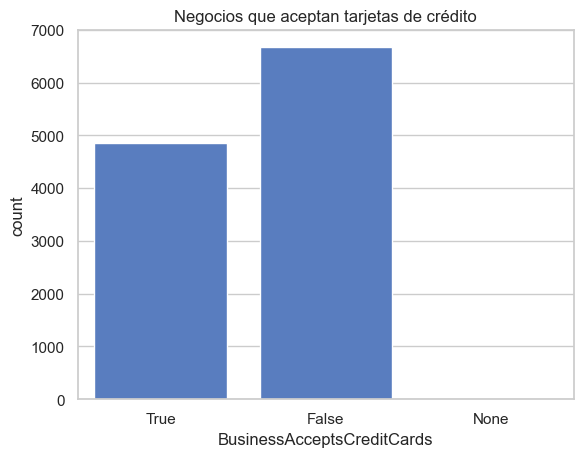

In [184]:
# Contar valores en la columna 'BusinessAcceptsCreditCards'
print(df_expanded['BusinessAcceptsCreditCards'].value_counts())

# Reemplazar 'None' o NaN con 'False' para un análisis más claro
df_expanded['BusinessAcceptsCreditCards'] = df_expanded['BusinessAcceptsCreditCards'].fillna('False')

# Gráfico de barras 
sns.countplot(data=df_expanded, x='BusinessAcceptsCreditCards')
plt.title("Negocios que aceptan tarjetas de crédito")
plt.show()

Interpretación: 
- La barra correspondiente a "False" (no aceptan tarjetas) es significativamente más alta que la de "True" (aceptan tarjetas). Esto indica que la gran mayoría de los restaurantes latinos en Estados Unidos han adoptado el uso de tarjetas de crédito como método de pago.
- La alta proporción de restaurantes que aceptan tarjetas de crédito refleja la creciente tendencia hacia los pagos electrónicos y la conveniencia que esto representa tanto para los clientes como para los negocios.

In [185]:
# Conteo de 'HasTV' y otros atributos
print(df_expanded['HasTV'].value_counts())
print(df_expanded['WiFi'].value_counts())

HasTV
True     3991
False     834
None        1
Name: count, dtype: int64
WiFi
u'no'      1422
u'free'    1307
'no'        856
'free'      493
u'paid'      19
'paid'       13
None          3
Name: count, dtype: int64


### Se carga el Dataset de los Estados con mayor población latina, con el objetivo que unir al df_expanded

In [186]:
states = pd.read_csv('D:/2024/HenryData/PF/Datos_Crudos/yelp/df_new/states.csv')

In [187]:
states.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state_id             558 non-null    int64  
 1   state_name           558 non-null    object 
 2   abbreviation         558 non-null    object 
 3   county_name          558 non-null    object 
 4   total_population     558 non-null    int64  
 5   hispanic_population  558 non-null    int64  
 6   avg_income           558 non-null    float64
dtypes: float64(1), int64(3), object(3)
memory usage: 30.6+ KB


In [188]:
states.head(2)

,state_id,state_name,abbreviation,county_name,total_population,hispanic_population,avg_income
0,6,Arizona,AZ,Apache,71602,4489,32268.56
1,6,Arizona,AZ,Cochise,126516,46922,46720.84


In [189]:
# Conteo de 'HasTV' y otros atributos
print(states['state_name'].unique())


['Arizona' 'California' 'Florida' 'Illinois' 'New York' 'Texas']


El DataFrame 'states' contiene información demográfica y socioeconómica de los 6 estados ('Arizona', 'California', 'Florida', 'Illinois', 'New York' y 'Texas') con mayor población latina de Estados Unidos. A continuación se describe cada una de las columnas que contiene el DataFame:

1. state_id: Identificador único asignado a cada estado. Es de tipo int64.

2. state_name: Nombre completo del estado. es de tipo objeto.


4. county_name: Nombre del condado o equivalente dentro del estado. es de tipo objeto.

5. total_population: Población total del Estado. Es de tipo int64.

6. hispanic_population: Número de personas de origen hispano o latino en el Estado. Es de tipo int64.

7. avg_income: Ingreso promedio per cápita de los residentes del Estado. Es de tipo float64.

Filtraremos los restaurantes latinos en base a estos 6 Estados, para ello primero unimos el df_expanded y states mediante la columna 'state_name', obtenemos un nuevo DataFrame 'restaurantes_latinos_filtrados'

In [190]:
restaurantes_latinos_filtrados = pd.merge(df_expanded, states, on='state_name', how='inner')

In [191]:
restaurantes_latinos_filtrados.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours,is_food_related,restaurante_categoria,state_name,BusinessAcceptsCreditCards,HasTV,OutdoorSeating,RestaurantsReservations,GoodForKids,RestaurantsPriceRange2,RestaurantsTakeOut,Caters,WiFi,RestaurantsAttire,NoiseLevel,BusinessParking,BikeParking,Alcohol,RestaurantsGoodForGroups,GoodForMeal,RestaurantsDelivery,Ambience,DriveThru,RestaurantsTableService,GoodForDancing,Smoking,CoatCheck,DogsAllowed,BestNights,Music,HappyHour,ByAppointmentOnly,BYOB,Corkage,BusinessAcceptsBitcoin,WheelchairAccessible,BYOBCorkage,DietaryRestrictions,AgesAllowed,Open24Hours,RestaurantsCounterService,state_id,abbreviation,county_name,total_population,hispanic_population,avg_income
0,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,10160 Ulmerton Rd,Largo,IN,33771,27.894167,-82.779866,3.0,19.0,1,"Mexican, Fast Food, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '10:45-22:0',...",True,[restaurante mexicano],Florida,True,True,False,False,True,2,True,False,'no',u'casual',u'average',"{'garage': False, 'street': False, 'validated'...",True,'full_bar',True,"{u'breakfast': None, u'brunch': False, u'lunch...",False,"{'touristy': False, 'hipster': False, 'romanti...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,FL,Alachua,253231,22837,46780.82
1,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,10160 Ulmerton Rd,Largo,IN,33771,27.894167,-82.779866,3.0,19.0,1,"Mexican, Fast Food, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '10:45-22:0',...",True,[restaurante mexicano],Florida,True,True,False,False,True,2,True,False,'no',u'casual',u'average',"{'garage': False, 'street': False, 'validated'...",True,'full_bar',True,"{u'breakfast': None, u'brunch': False, u'lunch...",False,"{'touristy': False, 'hipster': False, 'romanti...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,FL,Baker,27537,620,56274.50


In [192]:
restaurantes_latinos_filtrados.shape

(112379, 59)

Eliminamos los duplciados por la columna 'business_id'

In [193]:
restaurantes_latinos_filtrados = restaurantes_latinos_filtrados.drop_duplicates(subset='business_id')

In [194]:
restaurantes_latinos_filtrados.shape

(2098, 59)

Observamos que de los 6 Estados con mayor población latina, nuestro DataFrame 'restaurantes_latinos_filtrados', sólo cuenta con 4 Estados: 'Florida', 'California', 'Arizona' y 'Illinois'.

In [195]:
restaurantes_latinos_filtrados['state_name'].unique()

array(['Florida', 'California', 'Arizona', 'Illinois'], dtype=object)

In [196]:
nuevo_orden = ['business_id', 'name', 'restaurante_categoria','address', 'city', 'state_id', 'state_name', 'abbreviation', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'categories','BusinessAcceptsCreditCards','HasTV','OutdoorSeating', 'RestaurantsTakeOut','WiFi','RestaurantsAttire','NoiseLevel']
restaurantes_latinos_filtrados = restaurantes_latinos_filtrados.reindex(columns=nuevo_orden)

In [197]:
restaurantes_latinos_filtrados.head(2)

,business_id,name,restaurante_categoria,address,city,state_id,state_name,abbreviation,postal_code,latitude,longitude,stars,review_count,is_open,categories,BusinessAcceptsCreditCards,HasTV,OutdoorSeating,RestaurantsTakeOut,WiFi,RestaurantsAttire,NoiseLevel
0,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,[restaurante mexicano],10160 Ulmerton Rd,Largo,1,Florida,FL,33771,27.894167,-82.779866,3.0,19.0,1,"Mexican, Fast Food, Restaurants",True,True,False,True,'no',u'casual',u'average'
67,XwoXi0M66RU6Gouq-DSDHw,G Peppers Grill & Tavern,[restaurante mexicano],8745 Gunn Hwy,Odessa,1,Florida,FL,33556,28.092136,-82.578574,4.0,82.0,1,"Restaurants, Mexican, American (Traditional)",True,True,True,True,u'no',u'casual',u'quiet'


In [198]:
restaurantes_latinos_filtrados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2098 entries, 0 to 112312
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 2098 non-null   object 
 1   name                        2098 non-null   object 
 2   restaurante_categoria       2098 non-null   object 
 3   address                     2098 non-null   object 
 4   city                        2098 non-null   object 
 5   state_id                    2098 non-null   int64  
 6   state_name                  2098 non-null   object 
 7   abbreviation                2098 non-null   object 
 8   postal_code                 2098 non-null   object 
 9   latitude                    2098 non-null   float64
 10  longitude                   2098 non-null   float64
 11  stars                       2098 non-null   float64
 12  review_count                2098 non-null   float64
 13  is_open                     2098 non

In [199]:
categorical_columns = ['NoiseLevel', 'WiFi', 'HasTV', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'RestaurantsTakeOut', 'RestaurantsAttire']
for col in categorical_columns:
    restaurantes_latinos_filtrados[col].fillna('Desconocido', inplace=True)

In [200]:
print(restaurantes_latinos_filtrados.isnull().sum())

business_id                   0
name                          0
restaurante_categoria         0
address                       0
city                          0
state_id                      0
state_name                    0
abbreviation                  0
postal_code                   0
latitude                      0
longitude                     0
stars                         0
review_count                  0
is_open                       0
categories                    0
BusinessAcceptsCreditCards    0
HasTV                         0
OutdoorSeating                0
RestaurantsTakeOut            0
WiFi                          0
RestaurantsAttire             0
NoiseLevel                    0
dtype: int64


In [201]:
# Eliminar las comillas de los valores de la columna NoiseLevel
restaurantes_latinos_filtrados['NoiseLevel'] = restaurantes_latinos_filtrados['NoiseLevel'].str.replace("'", "")
restaurantes_latinos_filtrados['RestaurantsAttire'] = restaurantes_latinos_filtrados['RestaurantsAttire'].str.replace("'", "")
restaurantes_latinos_filtrados['WiFi'] = restaurantes_latinos_filtrados['WiFi'].str.replace("'", " ")

In [202]:
restaurantes_latinos_filtrados.head(2)

,business_id,name,restaurante_categoria,address,city,state_id,state_name,abbreviation,postal_code,latitude,longitude,stars,review_count,is_open,categories,BusinessAcceptsCreditCards,HasTV,OutdoorSeating,RestaurantsTakeOut,WiFi,RestaurantsAttire,NoiseLevel
0,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,[restaurante mexicano],10160 Ulmerton Rd,Largo,1,Florida,FL,33771,27.894167,-82.779866,3.0,19.0,1,"Mexican, Fast Food, Restaurants",True,True,False,True,no,ucasual,uaverage
67,XwoXi0M66RU6Gouq-DSDHw,G Peppers Grill & Tavern,[restaurante mexicano],8745 Gunn Hwy,Odessa,1,Florida,FL,33556,28.092136,-82.578574,4.0,82.0,1,"Restaurants, Mexican, American (Traditional)",True,True,True,True,u no,ucasual,uquiet


Manejo de valores 'None' en las columnas:

In [203]:
columns_to_replace = [
    'NoiseLevel', 
    'RestaurantsAttire', 
    'WiFi', 
    'BusinessAcceptsCreditCards', 
    'HasTV', 
    'OutdoorSeating', 
    'RestaurantsTakeOut'
]

# Reemplazar 'None' con 'Desconocido' para las columnas especificadas
restaurantes_latinos_filtrados[columns_to_replace] = restaurantes_latinos_filtrados[columns_to_replace].replace('None', 'Desconocido')

In [204]:
restaurantes_latinos_filtrados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2098 entries, 0 to 112312
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 2098 non-null   object 
 1   name                        2098 non-null   object 
 2   restaurante_categoria       2098 non-null   object 
 3   address                     2098 non-null   object 
 4   city                        2098 non-null   object 
 5   state_id                    2098 non-null   int64  
 6   state_name                  2098 non-null   object 
 7   abbreviation                2098 non-null   object 
 8   postal_code                 2098 non-null   object 
 9   latitude                    2098 non-null   float64
 10  longitude                   2098 non-null   float64
 11  stars                       2098 non-null   float64
 12  review_count                2098 non-null   float64
 13  is_open                     2098 non

Guardar archivo filtrado

In [205]:
restaurantes_latinos_filtrados.to_csv('D:/2024/HenryData/PF/Datos_Crudos/yelp/df_new/restaurantes_latinos_filtrados.csv', index=False)

-----

### Recortamos el dataset 'review'

In [206]:
# Ruta al archivo JSON
file_path = 'D:/2024/HenryData/PF/Datos_Crudos/yelp/review.json'

# Abrir el archivo especificando la codificación
with open(file_path, 'r', encoding='utf-8') as file:
    data = [json.loads(line) for line in file]

In [207]:
# Convertir los datos a un DataFrame de pandas
df_review = pd.DataFrame(data)

In [208]:
df_review.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18


In [209]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   useful       int64  
 5   funny        int64  
 6   cool         int64  
 7   text         object 
 8   date         object 
dtypes: float64(1), int64(3), object(5)
memory usage: 480.0+ MB


El DataFrame df_review contiene información sobre reseñas de negocios, incluyendo detalles como el usuario que la escribió, el negocio reseñado, la calificación otorgada, el texto de la reseña, la fecha de publicación y la interacción de otros usuarios con la reseña, a conitnuación se describe el detalle de cada una de las columnas del df_review:

1. review_id: Identificador único de cada reseña o comentario. Es de tipo objeto

2. user_id: Identificador único del usuario que escribió la reseña. Es de tipo objeto.

3. business_id: Identificador único del negocio o establecimiento al que se refiere la reseña. Es de tipo objeto.

4. stars: Calificación otorgada por el usuario al negocio, probablemente en una escala del 1 al 5. Es de tipo float64.

5. useful: Número de veces que otros usuarios han marcado esta reseña como "útil". Es de tipo int64.

6. funny: Número de veces que otros usuarios han marcado esta reseña como "graciosa" o "divertida". Es de tipo int64.

7. cool: Número de veces que otros usuarios han marcado esta reseña como "interesante" o "impresionante". Es de tipo int64.

8. text: Contenido textual de la reseña, es decir, el comentario escrito por el usuario. Es de tipo objeto.

9. date: Fecha y hora en que se publicó la reseña. Es de tipo objeto.

Filtraremos el DataFrame review mediante la calumna 'business_id', con la columna del mismo nombre de DataFrame "restaurantes_latinos_filtrados" (DataFrame que contiene información de sólo 4 Estados: 'Florida', 'California', 'Arizona' y 'Illinois'), obteniendo un nuevo DataFrame 'df_review_filtered'; y en base a este DataFrame realizaremos el análisis.

In [210]:
# Nos aseguramos que la columna 'business_id' en ambos dataframe sean de tipo string
df_review['business_id'] = df_review['business_id'].astype(str)
restaurantes_latinos_filtrados['business_id'] = restaurantes_latinos_filtrados['business_id'].astype(str)

In [211]:
# Filtra df_review para incluir solo los 'business_id' presentes en restaurantes_latinos_filtrados
df_review_filtered = df_review[df_review['business_id'].isin(restaurantes_latinos_filtrados['business_id'])]

In [212]:
# Verifica el tamaño del DataFrame original y el filtrado
print(f"Tamaño original de df_review: {df_review.shape}")
print(f"Tamaño de df_review filtrado: {df_review_filtered.shape}")

Tamaño original de df_review: (6990280, 9)
Tamaño de df_review filtrado: (218701, 9)


In [213]:
# Muestra las primeras filas del DataFrame filtrado
df_review_filtered.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
14,UBp0zWyH60Hmw6Fsasei7w,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4.0,0,2,0,The bun makes the Sonoran Dog. It's like a snu...,2011-10-27 17:12:05
47,TcCcHzc3L6Aboq3DteEfZA,OuatwND396ZQxm2zK8WlUQ,jNL5KUPz2-tHUJM__ysSaw,1.0,1,0,0,If you want to pay for everything a la carte t...,2014-08-24 20:14:12


Incluimos algunas columnas del DataFrame restaurantes_latinos_filtrados, para un análisis más detallado.

In [214]:
# Selecciona las columnas necesarias de restaurantes_latinos_filtrados
columns_to_add = ['business_id', 'name', 'restaurante_categoria', 'state_name']

# Realiza el merge
df_review_filtered = df_review_filtered.merge(
    restaurantes_latinos_filtrados[columns_to_add],
    on='business_id',
    how='inner'  # Unión basada en los 'business_id' comunes
)

In [215]:
# Verifica el tamaño y las primeras filas del DataFrame
print(f"Tamaño después del merge: {df_review_filtered.shape}")


Tamaño después del merge: (218701, 12)


In [216]:
df_review_filtered.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,restaurante_categoria,state_name
0,UBp0zWyH60Hmw6Fsasei7w,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4.0,0,2,0,The bun makes the Sonoran Dog. It's like a snu...,2011-10-27 17:12:05,BK Tacos,[restaurante mexicano],Arizona
1,TcCcHzc3L6Aboq3DteEfZA,OuatwND396ZQxm2zK8WlUQ,jNL5KUPz2-tHUJM__ysSaw,1.0,1,0,0,If you want to pay for everything a la carte t...,2014-08-24 20:14:12,El Chicanito Mexican Restaurant,[restaurante mexicano],Florida


In [217]:
df_review_filtered['state_name'].unique()

array(['Arizona', 'Florida', 'California', 'Illinois'], dtype=object)

Revisamos los nulos y duplicados del dataset filtrado

In [219]:
# Convertir columnas con listas a cadenas 
df_review_filtered = df_review_filtered.applymap(
    lambda x: str(x) if isinstance(x, list) else x
)

# Valores nulos por columna
print("Valores nulos por columna:")
print(df_review_filtered.isnull().sum())

# Filas duplicadas
print(f"Filas duplicadas: {df_review_filtered.duplicated().sum()}")

Valores nulos por columna:
review_id                0
user_id                  0
business_id              0
stars                    0
useful                   0
funny                    0
cool                     0
text                     0
date                     0
name                     0
restaurante_categoria    0
state_name               0
dtype: int64
Filas duplicadas: 0


Análisis del DataFrame 'df_review_filtered':

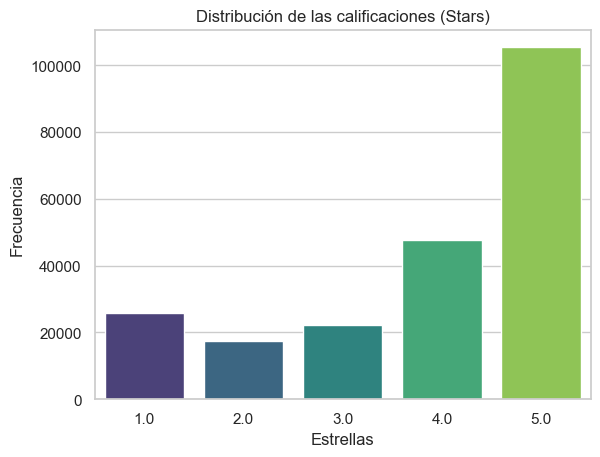

In [220]:
# Distribución de la columna 'stars'
sns.countplot(data=df_review_filtered, x='stars', palette='viridis')
plt.title("Distribución de las calificaciones (Stars)")
plt.xlabel("Estrellas")
plt.ylabel("Frecuencia")
plt.show()

Conclusiones:
- Del gráfico se puede observar que los restaurantes latinos de los 4 Estados 'Florida', 'California', 'Arizona' y 'Illinois' de Estados Unidos están siendo muy bien recibidos por sus clientes, ya que la barra correspondiente a las 5 estrellas es significativamente más alta que las demás, lo que sugiere que una gran proporción de los clientes están muy contentos con su experiencia culinaria en estos restaurante.
- La distribución de las calificaciones sigue un patrón en forma de "J", con una concentración alta en las calificaciones más altas y una disminución gradual a medida que bajamos en la escala. Esto es típico en muchos tipos de valoraciones, ya que los clientes suelen ser más propensos a dejar comentarios positivos que negativos.

Negocios más reseñados:
 name
Los Agaves                5192
Columbia Restaurant       3974
Chipotle Mexican Grill    3197
Taco Bus                  2679
El Charro Cafe            2627
Taco Bell                 2414
Capital Tacos             2323
Bodega                    2029
Lolis Mexican Cravings    1889
Tijuana Flats             1846
Name: count, dtype: int64


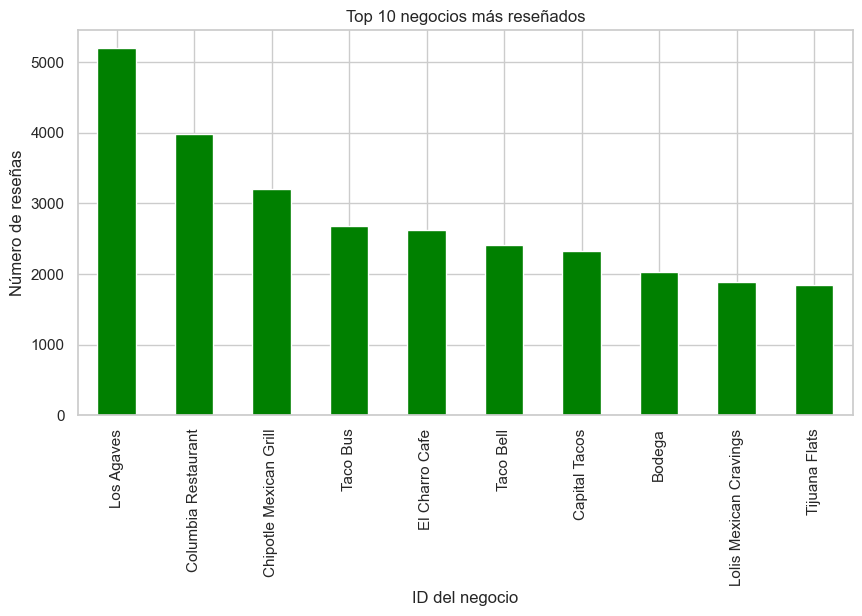

In [221]:
# Negocios con más reseñas
top_businesses = df_review_filtered['name'].value_counts().head(10)
print("Negocios más reseñados:\n", top_businesses)

# Visualizar
top_businesses.plot(kind='bar', figsize=(10, 5), color='green')
plt.title("Top 10 negocios más reseñados")
plt.xlabel("ID del negocio")
plt.ylabel("Número de reseñas")
plt.show()

Interpretación:
- El restaurante "Los Agaves" ocupa el primer lugar con una diferencia considerable respecto a los demás, lo que sugiere que es el más popular y reconocido entre los clientes en estos cuatro estados.
- La presencia de grandes cadenas como Chipotle Mexican Grill y Taco Bell en el top 10 indica una alta competencia en el sector de restaurantes latinos, incluso con restaurantes locales como "Los Agaves" y "Columbia Restaurant".

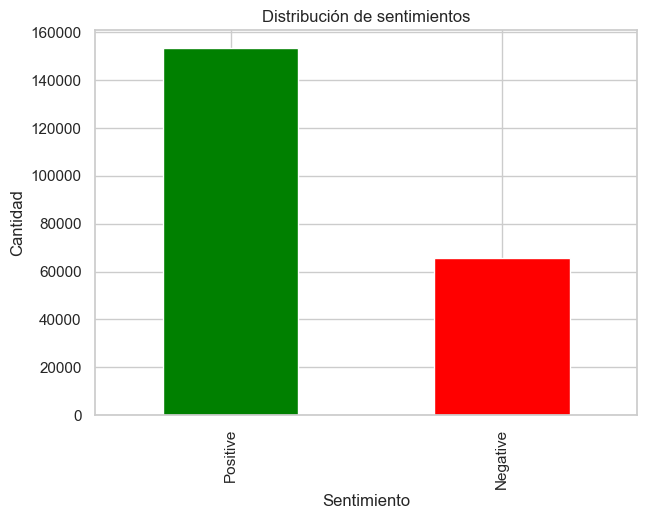

In [222]:
# Clasificar reseñas como positivas o negativas basadas en 'stars'
df_review_filtered['sentiment'] = df_review_filtered['stars'].apply(lambda x: 'Positive' if x >= 4 else 'Negative')

# Conteo de sentimientos
sentiment_counts = df_review_filtered['sentiment'].value_counts()

# Visualización
sentiment_counts.plot(kind='bar', figsize=(7, 5), color=['green', 'red'])
plt.title("Distribución de sentimientos")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad")
plt.show()

Interpretación:
- Es evidente que la mayoría de las reseñas y comentarios hacia los restaurantes latinos en estos estados son positivos. La barra verde, que representa los sentimientos positivos, es significativamente más alta que la barra roja, que representa los sentimientos negativos.
- Los clientes, en general, parecen estar satisfechos con la experiencia que tienen en los restaurantes latinos de estos estados. Esto podría deberse a diversos factores como la calidad de la comida, el servicio, la autenticidad de la cocina, o la atmósfera del lugar.

In [223]:
# Tomamos una muestra aleatoria de 10000 filas
muestra = df_review_filtered.sample(n=10000, random_state=42) 

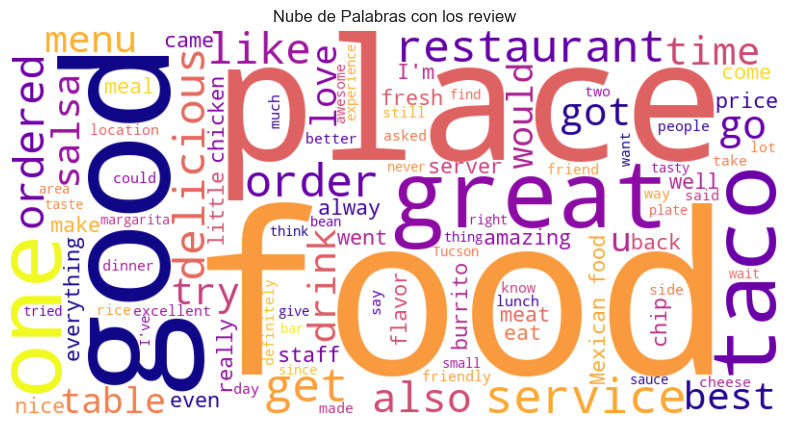

In [224]:
# Concatenamos todas las descripciones del título en una sola cadena
texto_nube = ' '.join(muestra['text'])

# Creamos la nube de palabras
nube_palabras = WordCloud(stopwords=stop_words, background_color='white', max_words=100, width=800, height=400, colormap='plasma').generate(texto_nube)

# Mostramos la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(nube_palabras, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras con los review')
plt.show()

Al observar la nube de palabras, podemos identificar los siguientes temas recurrentes:

- Comida: palabras como "comida", "delicioso", "sabor", "salsa", "carne", "taco", "burrito" y "plato" indican que la calidad y el sabor de la comida son aspectos muy valorados por los clientes.

- Servicio: términos como "servicio", "personal", "amable", "rápido" y "atención" sugieren que los clientes también valoran la calidad del servicio y la atención que reciben en los restaurantes.

- Experiencia general: palabras como "lugar", "ambiente", "restaurante", "excelente", "bueno" y "gran" se refieren a la experiencia general del cliente en el restaurante, incluyendo la atmósfera, la decoración y la comodidad.

- Valor: términos como "precio", "valor" y "barato" indican que los clientes también consideran la relación calidad-precio al evaluar un restaurante.

*En conslusión:*
- La calidad de la comida: El sabor auténtico y la variedad de platillos son aspectos fundamentales para los clientes.
- El servicio al cliente: Un trato amable y atento por parte del personal es muy apreciado.
- La experiencia general: Los clientes buscan un ambiente agradable y una experiencia culinaria satisfactoria.
- La relación calidad-precio: Los clientes buscan una buena relación entre la calidad de la comida y el precio que pagan.

Guardamos el Dataset Filtrado 

In [225]:
df_review_filtered.to_csv('D:/2024/HenryData/PF/Datos_Crudos/yelp/df_new/df_review_filtered.csv', index=False)
